# Atuomated Feature Generation 
https://github.com/blue-yonder/tsfresh

In [1]:
import sys
sys.path.append(
    "/Users/dmitrys/Desktop/DataProjects/otus-advanced-ml/Materials/13-ts-feature-extraction/"
)

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from tqdm.autonotebook import tqdm

# импортируем необходимые функции из библиотеки
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

from src.utils import *

In [3]:
INPUT_FOLDER_TRAIN = '../data/raw/UCI_HAR/train/InertialSignals/'
INPUT_FOLDER_TEST = '../data/raw/UCI_HAR/test/InertialSignals/'

LABELFILE_TRAIN = '../data/raw/UCI_HAR/train/y_train.txt'
LABELFILE_TEST = '../data/raw/UCI_HAR/test/y_test.txt'

train_signals, test_signals, train_labels, test_labels = read_data(
    input_folder_train=INPUT_FOLDER_TRAIN,
    input_folder_test=INPUT_FOLDER_TEST,
    labelfile_train=LABELFILE_TRAIN,
    labelfile_test=LABELFILE_TEST
)

train_signals, train_labels = randomize(train_signals, np.array(train_labels))
test_signals, test_labels = randomize(test_signals, np.array(test_labels))

In [4]:
train_signals.shape

(7352, 128, 9)

In [5]:
def get_long_dfs(data):
    long_dfs = []
    for signal in range(0, 9):
        signal_df_long = pd.DataFrame(
            {
                0: data[:, :, signal].reshape(-1),
                1: np.arange(data.shape[0]).repeat(data.shape[1])
            }
        )
        long_dfs.append(signal_df_long)
    return long_dfs

def extract_tsfeatures(data, settings):
    long_dfs = get_long_dfs(data)
    signal_features = []
    for signal in tqdm(range(0, 9), leave=False):
        s_features = extract_features(
            long_dfs[signal], column_id=1, 
            impute_function=impute, 
            default_fc_parameters=settings_efficient,
            n_jobs=6,
            disable_progressbar=True,
            show_warnings=False
        )
        signal_features.append(s_features)
    
    signal_features_df = pd.concat(signal_features, axis=1)
    return signal_features_df

In [6]:
#settings_efficient = settings.EfficientFCParameters()

settings_efficient = settings.TimeBasedFCParameters()
settings_efficient.update(settings.MinimalFCParameters())
settings_efficient.update(settings.IndexBasedFCParameters())
settings_efficient

{'linear_trend_timewise': [{'attr': 'pvalue'},
  {'attr': 'rvalue'},
  {'attr': 'intercept'},
  {'attr': 'slope'},
  {'attr': 'stderr'}],
 'sum_values': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variance': None,
 'maximum': None,
 'minimum': None,
 'skewness': None,
 'kurtosis': None,
 'percentage_of_reoccurring_values_to_all_values': None,
 'quantile': [{'q': 0.1},
  {'q': 0.2},
  {'q': 0.3},
  {'q': 0.4},
  {'q': 0.6},
  {'q': 0.7},
  {'q': 0.8},
  {'q': 0.9}]}

In [7]:
EXTRACT = True

if EXTRACT:
    X_train = extract_tsfeatures(train_signals, settings_efficient)
    X_test = extract_tsfeatures(test_signals, settings_efficient)
    X_train.to_csv('../data/processed/X_train_eff.csv')
    X_test.to_csv('../data/processed/X_test_eff.csv')
else:
    X_train = pd.read_csv('../data/processed/X_train_eff.csv', index_col=0)
    X_test = pd.read_csv('../data/processed/X_test_eff.csv', index_col=0)

In [8]:
# доюбавить сохранение y_train и y_test

In [9]:
Y_train = np.array(train_labels)
Y_test = np.array(test_labels)

In [10]:
X_train.head()

variable,0__kurtosis,0__length,0__maximum,0__mean,0__median,0__minimum,0__percentage_of_reoccurring_values_to_all_values,0__quantile__q_0.1,0__quantile__q_0.2,0__quantile__q_0.3,...,0__quantile__q_0.3,0__quantile__q_0.4,0__quantile__q_0.6,0__quantile__q_0.7,0__quantile__q_0.8,0__quantile__q_0.9,0__skewness,0__standard_deviation,0__sum_values,0__variance
id,,,,,,,,,,,,,,,,,,,,,
0,-0.822494,128.0,0.006152,0.000305,0.000785,-0.007353,0.0,-0.003488,-0.002690,-0.001769,...,0.308950,0.310487,0.312240,0.313464,0.314574,0.316184,-0.498126,0.004994,39.796513,0.000025
1,1.322495,128.0,0.797700,-0.008001,-0.097512,-0.335796,0.0,-0.243790,-0.195097,-0.163283,...,-0.049080,-0.033079,0.016916,0.071560,0.112814,0.236842,1.090667,0.148874,3.496987,0.022163
2,-0.055011,128.0,0.796968,0.000463,-0.020524,-0.515087,0.0,-0.347119,-0.277674,-0.206224,...,-0.113447,-0.093174,-0.000216,0.054919,0.115115,0.156696,0.550958,0.137284,-2.787231,0.018847
3,0.138542,128.0,0.497473,-0.020494,-0.031067,-0.517116,0.0,-0.248529,-0.206077,-0.134801,...,-0.345324,-0.290156,-0.221207,-0.141384,-0.077718,-0.045155,-0.360658,0.193459,-34.030293,0.037426
4,0.279090,128.0,0.008563,-0.000358,-0.000441,-0.005912,0.0,-0.003774,-0.002584,-0.001985,...,0.062372,0.063756,0.066468,0.067822,0.068906,0.070589,0.236987,0.005367,8.299124,0.000029


In [11]:
# Remove low variance features
selector = VarianceThreshold(threshold=0)
X_train_reduced = selector.fit_transform(X_train)
X_test_reduced = selector.transform(X_test)
X_train_reduced.shape

(7352, 162)

In [12]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_reduced, Y_train)
print("Accuracy on training set is : {}".format(clf.score(X_train_reduced, Y_train)))
print("Accuracy on test set is : {}".format(clf.score(X_test_reduced, Y_test)))
Y_test_pred = clf.predict(X_test_reduced)
print(classification_report(Y_test, Y_test_pred))

Accuracy on training set is : 1.0
Accuracy on test set is : 0.829996606718697
              precision    recall  f1-score   support

           1       0.67      0.70      0.68       496
           2       0.73      0.71      0.72       471
           3       0.86      0.84      0.85       420
           4       0.88      0.82      0.85       491
           5       0.84      0.89      0.87       532
           6       1.00      1.00      1.00       537

    accuracy                           0.83      2947
   macro avg       0.83      0.83      0.83      2947
weighted avg       0.83      0.83      0.83      2947



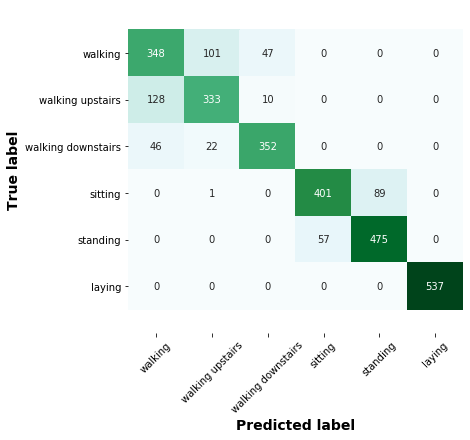

In [13]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',\
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}   
plot_confusion(Y_test, Y_test_pred, activities_description.values())